In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from patchify import patchify
from patchify import unpatchify

## Model Summary and Evaluation
* See scpript.py for the training script which was submited as a batch file onto TALC

## Model Definition

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # -------------------
        # Encoder (Downsampling path)
        # -------------------
        self.enc_conv1 = self.double_conv(in_channels, 64)  # 256x256 → 256x256
        self.pool1 = nn.MaxPool2d(2)                         # 256x256 → 128x128

        self.enc_conv2 = self.double_conv(64, 128)           # 128x128 → 128x128
        self.pool2 = nn.MaxPool2d(2)                         # 128x128 → 64x64

        self.enc_conv3 = self.double_conv(128, 256)          # 64x64 → 64x64
        self.pool3 = nn.MaxPool2d(2)                         # 64x64 → 32x32

        self.enc_conv4 = self.double_conv(256, 512)          # 32x32 → 32x32
        self.pool4 = nn.MaxPool2d(2)                         # 32x32 → 16x16

        # -------------------
        # Bottleneck
        # -------------------
        self.bottleneck = self.double_conv(512, 1024)        # 16x16 → 16x16

        # -------------------
        # Decoder (Upsampling path)
        # -------------------
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 16x16 → 32x32
        self.dec_conv4 = self.double_conv(1024, 512)        # 32x32 → 32x32 (after concatenating with encoder feature)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)   # 32x32 → 64x64
        self.dec_conv3 = self.double_conv(512, 256)        # 64x64 → 64x64

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)   # 64x64 → 128x128
        self.dec_conv2 = self.double_conv(256, 128)        # 128x128 → 128x128

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)    # 128x128 → 256x256
        self.dec_conv1 = self.double_conv(128, 64)         # 256x256 → 256x256

        # Final output layer: reduce to 1 output channel
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        # Sigmoid activation for binary segmentation (outputs in range [0, 1])
        self.activation = nn.Sigmoid()

    def double_conv(self, in_channels, out_channels):
        # Two sequential 3x3 convolutions with ReLU activations
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # -------------------
        # Encoding path
        # -------------------
        c1 = self.enc_conv1(x)  # 256x256
        p1 = self.pool1(c1)     # 128x128

        c2 = self.enc_conv2(p1) # 128x128
        p2 = self.pool2(c2)     # 64x64

        c3 = self.enc_conv3(p2) # 64x64
        p3 = self.pool3(c3)     # 32x32

        c4 = self.enc_conv4(p3) # 32x32
        p4 = self.pool4(c4)     # 16x16

        # -------------------
        # Bottleneck
        # -------------------
        bn = self.bottleneck(p4)  # 16x16

        # -------------------
        # Decoding path + skip connections
        # -------------------
        u4 = self.upconv4(bn)               # 16x16 → 32x32
        merge4 = torch.cat([u4, c4], dim=1) # skip connection with encoder
        d4 = self.dec_conv4(merge4)         # 32x32

        u3 = self.upconv3(d4)               # 32x32 → 64x64
        merge3 = torch.cat([u3, c3], dim=1)
        d3 = self.dec_conv3(merge3)         # 64x64

        u2 = self.upconv2(d3)               # 64x64 → 128x128
        merge2 = torch.cat([u2, c2], dim=1)
        d2 = self.dec_conv2(merge2)         # 128x128

        u1 = self.upconv1(d2)               # 128x128 → 256x256
        merge1 = torch.cat([u1, c1], dim=1)
        d1 = self.dec_conv1(merge1)         # 256x256

        # -------------------
        # Output layer
        # -------------------
        out_before_activation = self.out_conv(d1)  # 256x256 → 256x256 with 1 channel
        out = self.activation(out_before_activation)

        return out


## Test Dataset Preperation
Here we used the whole images (and not the patched ones).

In [3]:
class TumorSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, image_stats=[[0],[1]], mask_stats=[[0],[1]]):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.image_stats = image_stats
        self.mask_stats = mask_stats

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = self.mask_files[idx]

        img = Image.open(os.path.join(self.image_dir, img_name)).resize((512,512))
        mask = Image.open(os.path.join(self.mask_dir, mask_name)).resize((512,512))

        images = self.transform["image"](img)
        masks = self.transform["mask"](mask)
        return images, masks


In [4]:
base_dir = "/home/n-iznat/Desktop/DL/fp/dataset/"
train_image_dir = os.path.join(base_dir, "Dataset_split/Training/images")
train_mask_dir = os.path.join(base_dir, "Dataset_split/Training/masks")

val_image_dir = os.path.join(base_dir, "Dataset_split/Validation/images")
val_mask_dir = os.path.join(base_dir, "Dataset_split/Validation/masks")

test_image_dir = os.path.join(base_dir, "Dataset_split/Testing/images")
test_mask_dir = os.path.join(base_dir, "Dataset_split/Testing/masks")

transform = {
    "image": transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.], [1.0])]),
    "mask": transforms.Compose([transforms.ToTensor()])}
  


datasets = {
# "train": TumorSegmentationDataset(train_image_dir, train_mask_dir, transform=transform),
# "val": TumorSegmentationDataset(val_image_dir, val_mask_dir, transform=transform),
"test": TumorSegmentationDataset(test_image_dir, test_mask_dir, transform=transform),}


bs = 4

dataloaders = {
    # "train": DataLoader(datasets["train"], batch_size=bs, shuffle=True, num_workers=2),
    # "val": DataLoader(datasets["val"], batch_size=bs, shuffle=True, num_workers=2),
    "test": DataLoader(datasets["test"], batch_size=bs, shuffle=False, num_workers=2),
}


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Now using GPU if available
model = UNet(in_channels=1, out_channels=1).to(device)

/home/n-iznat/miniforge3/envs/dl/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Evaluate the Test Model

In [7]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_images = []
    all_pred_masks = []
    all_masks_gt = []
    batch_count = 0
    
    with torch.no_grad():
        for batch in test_loader:
            images = batch[0].to(device)
            masks_gt = batch[1].to(device) 
            pred_masks = model(images)
            batch_count += 1
            all_images.extend(images)
            all_masks_gt.extend(masks_gt)
            all_pred_masks.extend(pred_masks)
    
            if batch_count % 10 == 0:
                print(f"Processed {batch_count} batches")
            
    return all_images, all_masks_gt, all_pred_masks


In [11]:
model.load_state_dict(torch.load("/home/n-iznat/Desktop/DL/fp/best_unet.pth"))

/tmp/ipykernel_99616/1502371612.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/n-iznat/Desktop/DL/fp/best_unet.pth", map_locatio

<All keys matched successfully>

In [12]:
all_images, all_masks_gt, all_pred_masks = evaluate_model(model, dataloaders['test'], device)

Processed 10 batches
Processed 20 batches
Processed 30 batches
Processed 40 batches
Processed 50 batches
Processed 60 batches
Processed 70 batches
Processed 80 batches
Processed 90 batches
Processed 100 batches
Processed 110 batches


In [13]:
images = []
masks_gt = []
pred_masks = []
for i in range(len(all_images)):
    images.append(transforms.ToPILImage()(all_images[i].squeeze()))
    masks_gt.append(transforms.ToPILImage()(all_masks_gt[i].squeeze()))
    pred_masks.append(Image.fromarray((all_pred_masks[i].squeeze().cpu().numpy() >= 0.5).astype(np.uint8)*255))

## Visualize Results

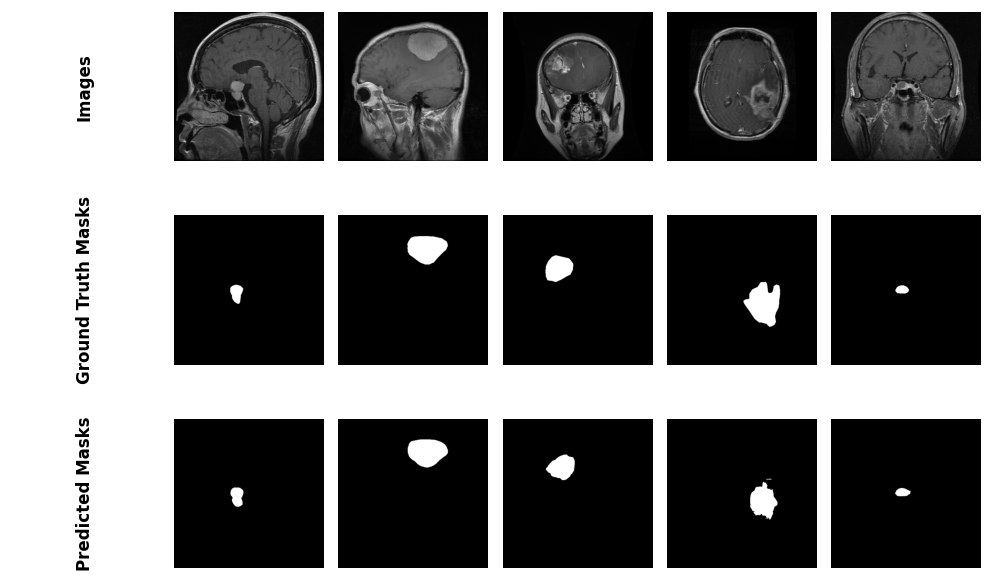

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Select random indices
num = np.random.randint(0, len(all_images), size=(5,))

fig, ax = plt.subplots(3, len(num) + 1, figsize=(10, 6))  

titles = ["Images", "Ground Truth Masks", "Predicted Masks"]
for row, title in enumerate(titles):
    ax[row][0].text(0.5, 0.5, title, fontsize=12, fontweight='bold',
                    ha='center', va='center', rotation=90)
    ax[row][0].axis("off")

for col in range(len(num)):
    ax[0][col + 1].imshow(images[num[col]], cmap='gray')
    ax[1][col + 1].imshow(masks_gt[num[col]], cmap='gray')
    ax[2][col + 1].imshow(pred_masks[num[col]], cmap='gray')

    for row in range(3):
        ax[row][col + 1].axis("off")

plt.tight_layout()
# plt.savefig("visual.png")
# plt.savefig("visual.pdf")
plt.show()


## Evaluate Test Set Accuracy with Dice Coefficient

In [31]:
def dice_coefficient(preds, targets, threshold=0.5, epsilon=1e-6):
    # Dice coefficient (float)

    # Binarize predictions
    preds = (preds > threshold).float()

    # Flatten tensors
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)

    # Compute Dice
    intersection = (preds * targets).sum(dim=1)
    dice = (2. * intersection + epsilon) / (preds.sum(dim=1) + targets.sum(dim=1) + epsilon)

    return dice.mean().item()


In [34]:
dc = 0
num = 0
jc = 0
for i in range(0,len(all_pred_masks)):
    dc += dice_coefficient(all_pred_masks[i], all_masks_gt[i])    
    num += 1
print("Dice Coefficient =", dc/num)

Dice Coefficient = 0.6775938578008494


# Dice Coefficient = 0.6776